In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
import distrax
from datasets import sin_data
import tensorflow_probability.substrates.jax as tfp

from models import gaussian_mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var

In [3]:
X, y, x_test_1, y_test_1, x_test_2, y_test_2 = sin_data.load_data()

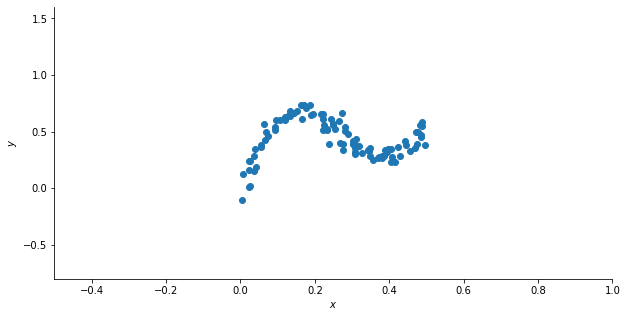

In [4]:
plt.figure(figsize=(10,5))
plt.scatter(X,y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
sns.despine()
plt.show()

In [5]:
model = gaussian_mlp.gmlp(features=[32, 32], activations=[nn.elu, nn.elu], dropout_rate=[0.03, 0.03])

In [6]:
params = model.init(jax.random.PRNGKey(0), X, True)

In [7]:
# params, loss = fit(model, params, auxs, learning_rate=0.01, epochs=2000, verbose=True)
params, loss = fit(model, params, X, y, deterministic=True, batch_size=32, learning_rate=0.01, epochs=1000)

In [8]:
x = jnp.linspace(0,0.5,100).reshape((-1,1))

In [9]:
# mean, sigma = model.apply(params, X, dropout=True)
y_hat = model.apply(params, x, True)

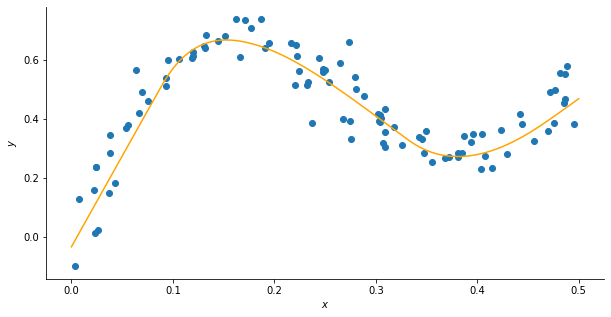

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(X, y)
plt.plot(x, y_hat[0], color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

## MC_Dropout

In [11]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
n_stacks = 100
mean_stacks = []
sigma_stacks = []
for i in range(n_stacks):
    y_stack = model.apply(params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
    mean_stacks.append(y_stack[0])
    sigma_stacks.append(y_stack[1])

In [12]:
mean, sigma = gmm_mean_var(mean_stacks, sigma_stacks)

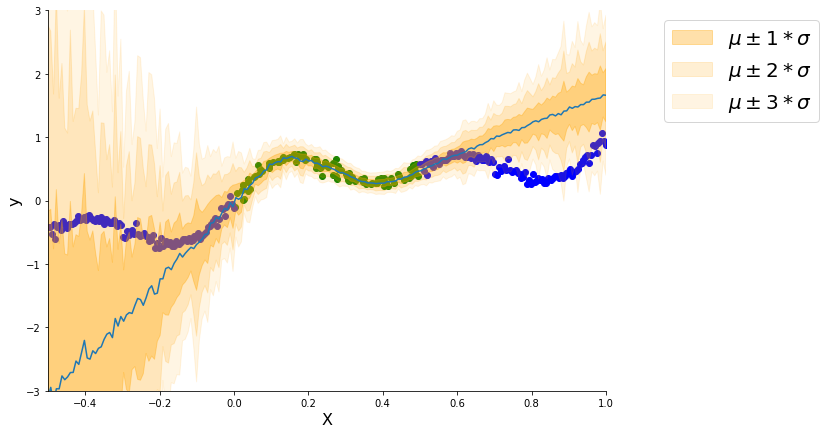

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, c="g")
plt.scatter(x_test_1, y_test_1, c="b")
plt.scatter(x_test_2, y_test_2, c="b")
plt.plot(x, mean)

for i in range(1,4):
    plt.fill_between(x.squeeze(), mean - i*sigma, mean + i*sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-0.5, 1.0)
plt.ylim(-3,3)
plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")